### Import libraries

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inspect
import pickle
import os
import glob
import numpy as np

In [157]:
plt.rcParams.update(plt.rcParamsDefault)

In [66]:
# 1.3 for single, 1.7 for triple, 2.25 for quadruple
sns.set_theme(style='ticks', font_scale=1.7)

### Accuracy, precision, recall

In [56]:
def construct_graphs(output_dir):
    print(output_dir)
    raw_df = pd.read_csv(f'{output_dir}/raw.csv')
    print(len(raw_df))

    with open(f'{output_dir}/metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)

    print("Number of relevant nodes in precision:", sum(metadata['number_of_nn_within_radius']) / len(metadata['number_of_nn_within_radius']))

    # rename columns
    raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR', 'SM'])]
    raw_df['method'] = raw_df['method'].replace({'DP-TT-CMP': 'DP-TT', 'LAPLACE': 'Laplace', 'SM': 'Square'})
    raw_df['Mechanism'] = raw_df['method']

    # remove jitter from graph
    no_jitter_df = pd.DataFrame()
    for early_stopping_level in raw_df['early_stopping_level'].unique():
        tmp_df = raw_df[raw_df['early_stopping_level'] == early_stopping_level]

        epsilon_distributions = tmp_df['eps_cmp'].value_counts().tolist()
        jitter_threshold = epsilon_distributions[len(metadata['epsilons']) - 1]
    
        frequent_values_index = tmp_df['eps_cmp'].value_counts()[tmp_df['eps_cmp'].value_counts() >= jitter_threshold].index
        no_jitter_df = pd.concat([no_jitter_df, tmp_df[tmp_df['eps_cmp'].isin(frequent_values_index)]])

        print(f"Jitter threshold for level {early_stopping_level-1}:", jitter_threshold)

    raw_df = no_jitter_df

    # change early_stopping_level to return_size
    for early_stopping_level in raw_df['early_stopping_level'].unique():
        raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = round(raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean(), 2)
    raw_df['Return Set Size'] = raw_df['return_size']
    raw_df['early_stopping_level'] -= 1

    # SMALLER EPSILON => LARGER MSE!
    raw_df['avg_mse'] = raw_df.groupby('eps')['mse'].transform('mean') # avg mse should be done w.r.t. group

    # correct 10^3 -> sqrt(10^7), m -> km
    raw_df['avg_mse'] *= np.sqrt(10) / 1000

    # graphs for these four
    metric_name = {
        'raw_acc': 'Raw Accuracy',
        'top_5_acc': 'Top 5 Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
        # 'mse': 'MSE',
    }

    for early_stopping_level in raw_df['early_stopping_level'].unique():
        if early_stopping_level == 'all':
            tmp_df = raw_df
        else:
            tmp_df = raw_df[raw_df['early_stopping_level'] == early_stopping_level]

        for metric in ['precision', 'recall']: # precision and recall considers top K values relevant

            # plot for both DP-TT and LDP
            if early_stopping_level == 'all':
                plot = sns.lineplot(
                    data=tmp_df, x='avg_mse', y=f'{metric}', 
                    hue='Return Set Size', style='Mechanism', markers=True,
                    palette='deep', alpha=0.75,
                )
            else:
                plot = sns.lineplot(
                    data=tmp_df, x='avg_mse', y=f'{metric}', 
                    hue='Mechanism',
                    style='Mechanism', markers=True,
                    alpha=0.75,
                )

            # graph params
            plot.set(
        #         xlim=(0, 10),
                xlabel='AdvError at ε (km)',
                ylabel=metric_name[metric]
            )
            if metric != 'mse':
                plot.set(ylim=(-0.1, 1.1))

            # move legend
            sns.move_legend(plot, "upper right")

            if early_stopping_level != 0:
                plt.legend([],[], frameon=False)

            # save plot
            plot.get_figure().savefig(f'{output_dir}/{metric}_{early_stopping_level}.png', bbox_inches='tight', dpi=400)
            plt.close()
            plot.get_figure().clf()


    # # precision-recall curves
    # os.makedirs(f'{output_dir}/precision_recall/', exist_ok=True)
    # files = glob.glob(f'{output_dir}/precision_recall/*')
    # for f in files:
    #     os.remove(f)

    # for eps in raw_df['base_eps'].unique():
    #     tmp_df = raw_df[raw_df['base_eps'] == eps].groupby(['Mechanism', 'early_stopping_level'])
    #     mean_df = tmp_df[['precision', 'recall', 'mse']].mean().reset_index()

    #     # plot for both DP-TT and LDP
    #     plot = sns.lineplot(
    #         data=mean_df, x='recall', y='precision', 
    #         style='Mechanism', markers=True, alpha=0.75,
    #         # palette='deep',
    #     )

    #     # graph params
    #     plot.set(
    #         ylim=(-0.1, 1.1),
    #         xlim=(-0.1, 1.1),
    #         ylabel='Precision',
    #         xlabel='Recall',
    #         # title=f'Precision vs. recall for epsilon = {round(eps, 2)}'
    #     )

    #     # move legend
    #     sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

        # # save file
        # # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        # #     display(tmp_df["eps_cmp"].unique())
        # # mse_std = round(tmp_df['mse'].std(), 2)

        # # for i, row in mean_df.iterrows():
        # #     plt.text(row['recall'], row['precision'] + 0.015,  # Adjust position as needed
        # #             round(row['mse'], 2),  # Formatting the label
        # #             horizontalalignment='center',
        # #             fontdict={'size': 5})
        # # return
        # mean_mse = mean_df['mse'].mean()

        # plot.get_figure().savefig(f'{output_dir}/precision_recall/mse_{round(mean_mse, 2)}.png', bbox_inches='tight', dpi=400)
        # plt.close()
        # plot.get_figure().clf()

    

In [58]:
construct_graphs('graphs/densities/1000000')

graphs/densities/1000000
12000
Number of relevant nodes in precision: 31.288
Jitter threshold for level 4: 1500


In [51]:
def construct_mse(output_dir):
    print(output_dir)
    raw_df = pd.read_csv(f'{output_dir}/raw.csv')

    with open(f'{output_dir}/metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)

    # rename columns
    raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR', 'SM'])]
    raw_df['method'] = raw_df['method'].replace({'DP-TT-CMP': 'DP-TT', 'LAPLACE': 'Laplace', 'SM': 'Square'})
    raw_df['Mechanism'] = raw_df['method']

    # remove jitter from graph
    no_jitter_df = pd.DataFrame()
    for early_stopping_level in raw_df['early_stopping_level'].unique():
        tmp_df = raw_df[raw_df['early_stopping_level'] == early_stopping_level]

        epsilon_distributions = tmp_df['eps_cmp'].value_counts().tolist()
        print(epsilon_distributions)
        jitter_threshold = epsilon_distributions[len(metadata['epsilons']) - 1]
    
        frequent_values_index = tmp_df['eps_cmp'].value_counts()[tmp_df['eps_cmp'].value_counts() >= jitter_threshold].index
        no_jitter_df = pd.concat([no_jitter_df, tmp_df[tmp_df['eps_cmp'].isin(frequent_values_index)]])

        print(f"Jitter threshold for level {early_stopping_level-1}:", jitter_threshold)

    raw_df = no_jitter_df

    # change early_stopping_level to return_size
    for early_stopping_level in [1]:
        raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = round(raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean(), 2)
    raw_df['Return Set Size'] = raw_df['return_size']
    raw_df['early_stopping_level'] -= 1


    # graphs for these four
    metric_name = {
        'raw_acc': 'Raw Accuracy',
        'top_5_acc': 'Top 5 Accuracy',
        'mse': 'MSE',
    }

    for early_stopping_level in [0, 2, 4, 6]:
        tmp_df = raw_df[raw_df['early_stopping_level'] == early_stopping_level]
        print(len(tmp_df))

        plot = sns.lineplot(
            data=tmp_df, x='eps', y=f'mse', 
            hue='Mechanism',
            style='Mechanism', markers=True,
            alpha=0.75,
        )

        # graph params
        plot.set(
            # xlim=(0, 10),
            # ylim=(-100, 1000),
            xlabel='Differential Privacy Budget ε',
            ylabel='AdvError'
        )

        # move legend
        sns.move_legend(plot, "upper right")

        # save plot
        plot.get_figure().savefig(f'{output_dir}/mse_{early_stopping_level}.png', bbox_inches='tight', dpi=400)
        plt.close()
        plot.get_figure().clf()


In [52]:
construct_mse('graphs/densities/100000')

graphs/densities/100000
[933, 882, 852, 843, 822, 810, 807, 759, 741, 693, 690, 678, 657, 648, 618, 567]
Jitter threshold for level 0: 759
[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]
Jitter threshold for level 2: 1500
[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]
Jitter threshold for level 4: 1500
[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]
Jitter threshold for level 6: 1500
6708
12000
12000
12000


In [4]:
all_output_dirs = [
    'graphs/densities/1000',
    'graphs/densities/10000',
    'graphs/densities/100000',
    'graphs/densities/1000000',
    'graphs/gowalla/austin/',
    'graphs/gowalla/sf/',
    'graphs/1d/1000/',
    'graphs/1d/10000/',
    'graphs/1d/100000/',
]

In [26]:
for output_dir in all_output_dirs:
    construct_graphs(output_dir)

graphs/densities/1000
Number of relevant nodes in precision: 28.71
Jitter threshold: 1404
graphs/densities/10000
Number of relevant nodes in precision: 30.578
Jitter threshold: 1065
graphs/densities/100000
Number of relevant nodes in precision: 31.294
Jitter threshold: 777
graphs/densities/1000000
Number of relevant nodes in precision: 31.662
Jitter threshold: 1263
graphs/gowalla/austin/
Number of relevant nodes in precision: 35.655310621242485
Jitter threshold: 762
graphs/gowalla/sf/
Number of relevant nodes in precision: 24.058
Jitter threshold: 1332
graphs/1d/1000/
Number of relevant nodes in precision: 35.288
Jitter threshold: 834
graphs/1d/10000/
Number of relevant nodes in precision: 35.352
Jitter threshold: 596
graphs/1d/100000/
Number of relevant nodes in precision: 24.874
Jitter threshold: 520


### DIS Exploration

In [2]:
db_size = 10 ** 6
domain = 10 ** 7

output_dir = f'graphs/densities/size_{db_size}_domain_{domain}/'
raw_df = pd.read_csv(f'{output_dir}raw.csv')

with open(f'{output_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [3]:
raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE-GEO'])]
# raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP', 'LAPLACE', 'L-SRR'])]

In [4]:
for early_stopping_level in [1, 3, 5, 9]:
    raw_df.loc[raw_df['early_stopping_level'] == early_stopping_level, 'return_size'] = round(raw_df[raw_df['early_stopping_level'] == early_stopping_level]['return_size'].mean(), 2)

In [5]:
raw_df['geo_eps'] = (raw_df['geo_eps'] / 500).round().astype(int) * 500

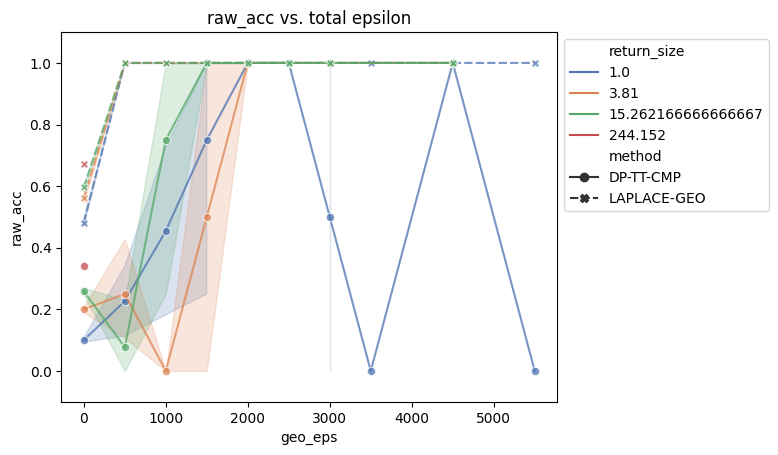

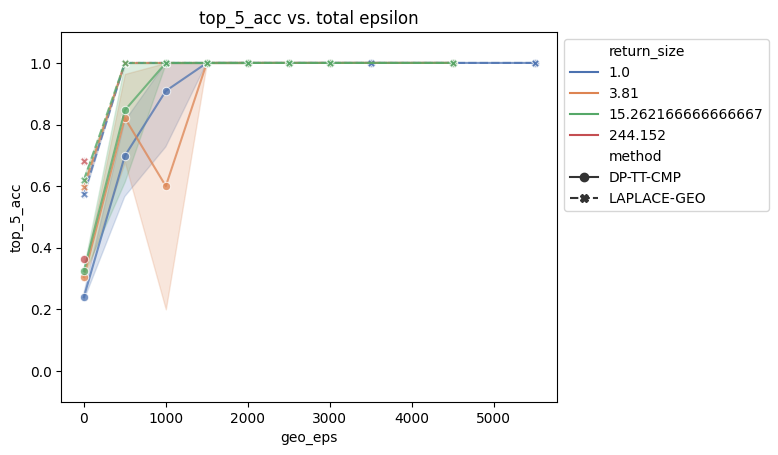

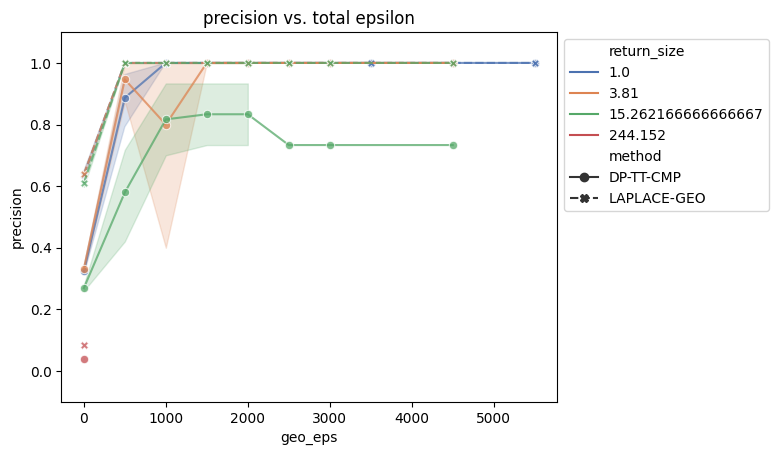

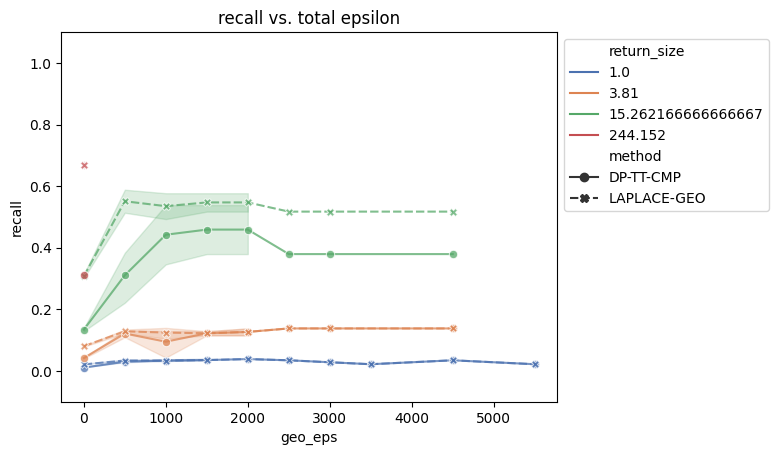

In [6]:
for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='geo_eps', y=f'{metric}', 
        hue='return_size', style='method', markers=True,
        palette='deep', alpha=0.75,
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
#         xlim=(0, 10),
        title=f'{metric} vs. total epsilon'
    )

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

    # save plot
    # plot.get_figure().savefig(f'{output_dir}/dis/{metric}_dis.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()

### Scheduler Graphs

In [125]:
db_size = 10 ** 5
domain = 10 ** 7

input_dir = f'graphs/scheduling/'
output_dir = f'graphs/scheduling/'
raw_df = pd.read_csv(f'{input_dir}raw.csv')

with open(f'{input_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

In [126]:
print("Number of relevant nodes in precision:", sum(metadata['number_of_nn_within_radius']) / len(metadata['number_of_nn_within_radius']))

# rename columns
raw_df = raw_df[raw_df['method'].isin(['DP-TT-CMP'])]
raw_df['method'] = raw_df['method'].replace({'DP-TT-CMP': 'DP-TT', 'LAPLACE': 'Laplace', 'SM': 'Square'})
raw_df['Mechanism'] = raw_df['method']

Number of relevant nodes in precision: 31.446


In [127]:
# remove jitter from graph
no_jitter_df = pd.DataFrame()
for scheduler_type in raw_df['scheduler_type'].unique():
    tmp_df = raw_df[raw_df['scheduler_type'] == scheduler_type]

    epsilon_distributions = tmp_df['eps_cmp'].value_counts().tolist()
    jitter_threshold = epsilon_distributions[len(metadata['epsilons']) - 1]

    frequent_values_index = tmp_df['eps_cmp'].value_counts()[tmp_df['eps_cmp'].value_counts() >= jitter_threshold].index
    no_jitter_df = pd.concat([no_jitter_df, tmp_df[tmp_df['eps_cmp'].isin(frequent_values_index)]])

    print(f"Jitter threshold for scheduler {scheduler_type}:", jitter_threshold)

raw_df = no_jitter_df

Jitter threshold for scheduler constant: 263
Jitter threshold for scheduler linear_increase_1: 268
Jitter threshold for scheduler linear_increase_2: 258
Jitter threshold for scheduler linear_increase_3: 282
Jitter threshold for scheduler linear_decrease_1: 251
Jitter threshold for scheduler linear_decrease_2: 250
Jitter threshold for scheduler linear_decrease_3: 251


In [128]:
# SMALLER EPSILON => LARGER MSE!
raw_df['avg_mse'] = raw_df.groupby('eps')['mse'].transform('mean') # avg mse should be done w.r.t. group

In [90]:
raw_df = raw_df[raw_df['scheduler_type'].isin(['constant', 'linear_decrease', 'linear_increase'])]

In [129]:

# graphs for these four
metric_name = {
    'raw_acc': 'Raw Accuracy',
    'top_5_acc': 'Top 5 Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    # 'mse': 'MSE',
}

for metric in ['raw_acc', 'top_5_acc', 'precision', 'recall']: # precision and recall considers top K values relevant

    plot = sns.lineplot(
        data=raw_df, x='avg_mse', y=f'{metric}', 
        hue='scheduler_type', palette='colorblind', marker='o',
        alpha=0.75,
    )

    # graph params
    plot.set(
#         xlim=(0, 10),
        xlabel='Average MSE at Epsilon',
        ylabel=metric_name[metric]
    )
    if metric != 'mse':
        plot.set(ylim=(-0.1, 1.1))

    # move legend
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

    # save plot
    os.makedirs(f'{output_dir}/', exist_ok=True)
    plot.get_figure().savefig(f'{output_dir}/{metric}.png', bbox_inches='tight', dpi=400)
    plt.close()
    plot.get_figure().clf()

## Old Scheduler Graphs

In [75]:
input_dir = f'graphs/legacy/schedulers/scheduler_1.2/size_100000_domain_10000000/'
output_dir = f'graphs/legacy/schedulers/scheduler_1.2/size_100000_domain_10000000/'
# input_dir = f'graphs/scheduler/linear/'
# output_dir = f'graphs/scheduler/linear/'
raw_df = pd.read_csv(f'{input_dir}raw.csv')

with open(f'{input_dir}metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

metric_name = {
    'raw_acc': 'Raw Accuracy',
    'top_5_acc': 'Top 5 Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    # 'mse': 'MSE',
}

In [76]:
# remove jitter from graph
no_jitter_df = pd.DataFrame()
for scheduler_type in raw_df['scheduler_type'].unique():
    tmp_df = raw_df[raw_df['scheduler_type'] == scheduler_type]

    epsilon_distributions = tmp_df['eps'].value_counts().tolist()
    # jitter_threshold = epsilon_distributions[len(metadata['epsilons']) - 1]
    jitter_threshold = epsilon_distributions[11]

    frequent_values_index = tmp_df['eps'].value_counts()[tmp_df['eps'].value_counts() >= jitter_threshold].index
    no_jitter_df = pd.concat([no_jitter_df, tmp_df[tmp_df['eps'].isin(frequent_values_index)]])

    print(f"Jitter threshold for scheduler {scheduler_type}:", jitter_threshold)

raw_df = no_jitter_df

Jitter threshold for scheduler constant: 500
Jitter threshold for scheduler linear: 500
Jitter threshold for scheduler log: 500
Jitter threshold for scheduler sqrt: 500
Jitter threshold for scheduler quadratic: 500


In [77]:
# raw_df = raw_df[raw_df['scheduler_type'].isin(['constant', 'linear_decrease_2', 'linear_increase_2', 'linear_decrease_3', 'linear_increase_3'])]
raw_df = raw_df[raw_df['scheduler_type'].isin(['constant', 'linear', 'log', 'sqrt', 'quadratic'])]
raw_df['scheduler_type'] = raw_df['scheduler_type'].replace({'constant': 'Constant', 'linear_decrease_2': 'Linear Decrease 1', 'linear_increase_2': 'Linear Increase 1', 'linear_decrease_3': 'Linear Decrease 2', 'linear_increase_3': 'Linear Increase 2', 'linear': 'Linear', 'log': 'Log', 'sqrt': 'Square Root', 'quadratic': 'Quadratic'})
raw_df['Scheduler'] = raw_df['scheduler_type']

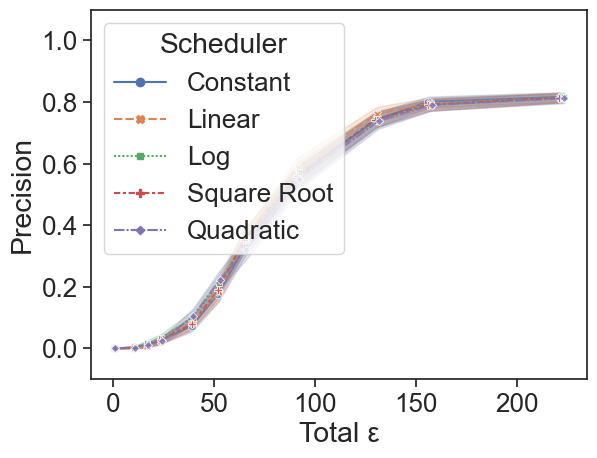

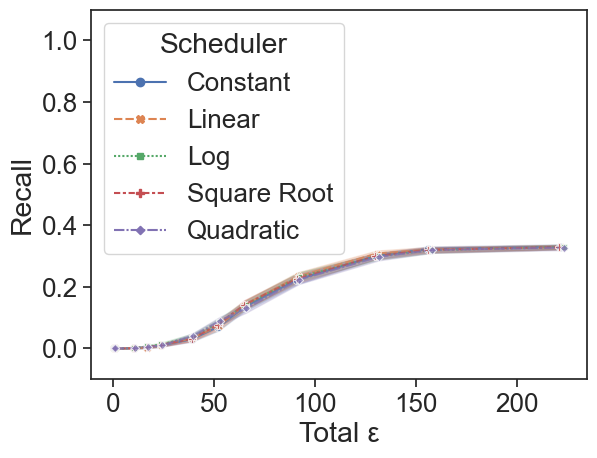

In [81]:
for metric in ['precision', 'recall']: # precision and recall considers top K values relevant

    # plot for both DP-TT and LDP
    plot = sns.lineplot(
        data=raw_df, x='eps', y=f'{metric}', 
        hue='Scheduler',
        palette='deep', alpha=0.75, style='Scheduler', markers=True,
    )

    # graph params
    plot.set(
        ylim=(-0.1, 1.1),
        xlabel='Total ε',
        ylabel=metric_name[metric]
    )

    # move legend
    sns.move_legend(plot, "upper left")

    # if metric == 'precision':
    #     plt.legend([],[], frameon=False)
    # plt.legend([],[], frameon=False)
    
    plt.show()

    # save plot
    plot.get_figure().savefig(f'{output_dir}{metric}.png', bbox_inches='tight', dpi=400)
    plot.get_figure().clf()